## Import Packages

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pprint import pprint
from tqdm import tqdm

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from ts.utility import Utility
from ts.experimental import GeneralizedParetoDistribution, GpdEstimate, Pso

## Load Dataset

In [2]:
rainfall_df = pd.read_csv('../datasets/rainfall-data.csv')[['YEAR', 'MN', 'DT', '..R/F']]
rainfall_df

,YEAR,MN,DT,..R/F
0,1970,1,1,0.0
1,1970,1,2,3.2
2,1970,1,3,0.0
3,1970,1,4,0.0
4,1970,1,5,0.0
...,...,...,...,...
17647,2018,4,26,0.0
17648,2018,4,27,2.1
17649,2018,4,28,0.0
17650,2018,4,29,0.0


### Get Rainfall Series

In [3]:
rainfall_series = rainfall_df['..R/F'].to_numpy()
n = rainfall_series.shape[0]

print(f'Rainfall data: datatype: {rainfall_series.dtype}, '
    + f'shape: {rainfall_series.shape}')

Rainfall data: datatype: float64, shape: (17652,)


## Train-Test Split

In [4]:
train_frac = 0.85
num_train = int(n * train_frac)

### Plot Entire Data

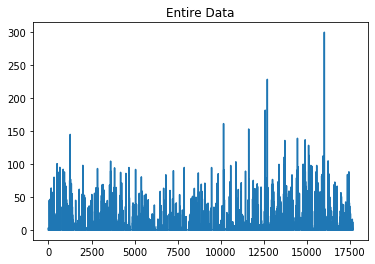

In [5]:
plt.plot(rainfall_series)
plt.title('Entire Data')
plt.show()

### All Data Histogram

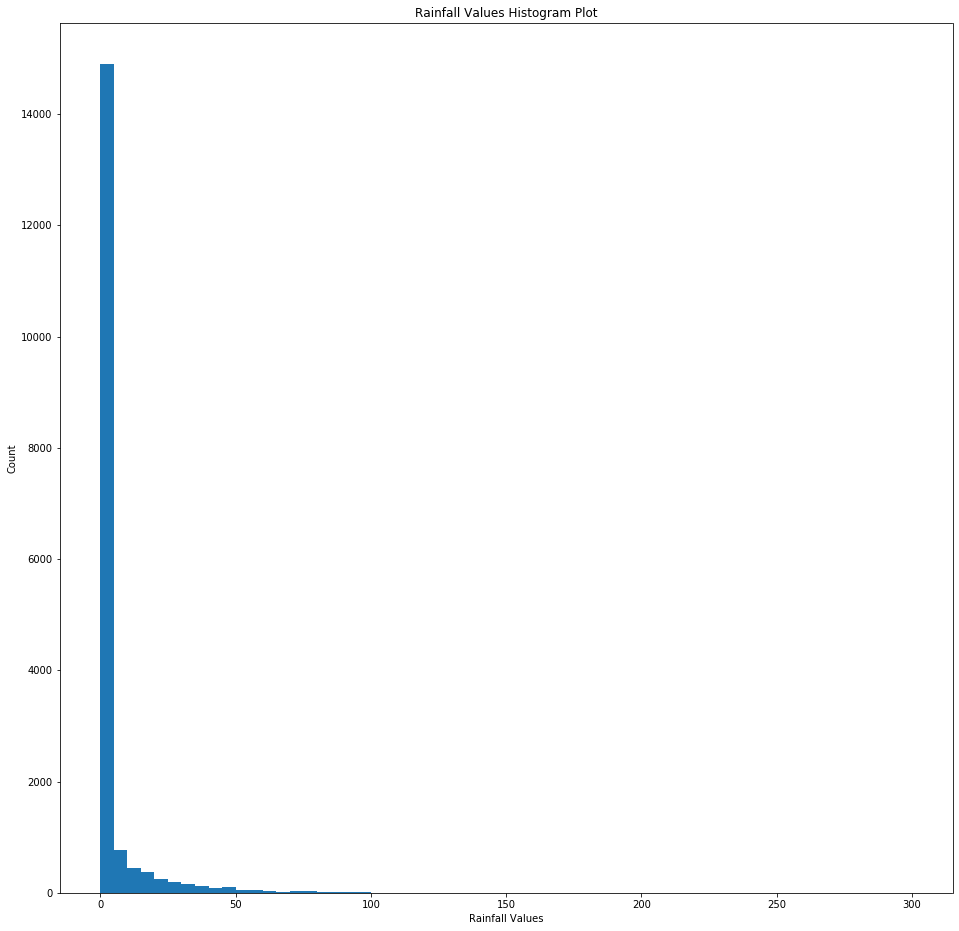

In [6]:
bin_width = 5
bins = np.arange(
    rainfall_series.min(), rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(16, 16))
plt.hist(rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Data histogram of values above a lower bound

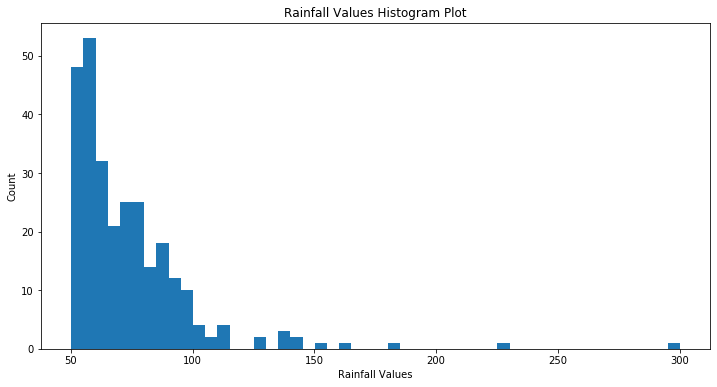

In [7]:
lower_bound = 50

bounded_rainfall_series = \
    rainfall_series[rainfall_series > lower_bound]

bin_width = 5
bins = np.arange(
    bounded_rainfall_series.min(), 
    bounded_rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(12, 6))
plt.hist(bounded_rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Complementary Cumulative Data of values above a lower bound

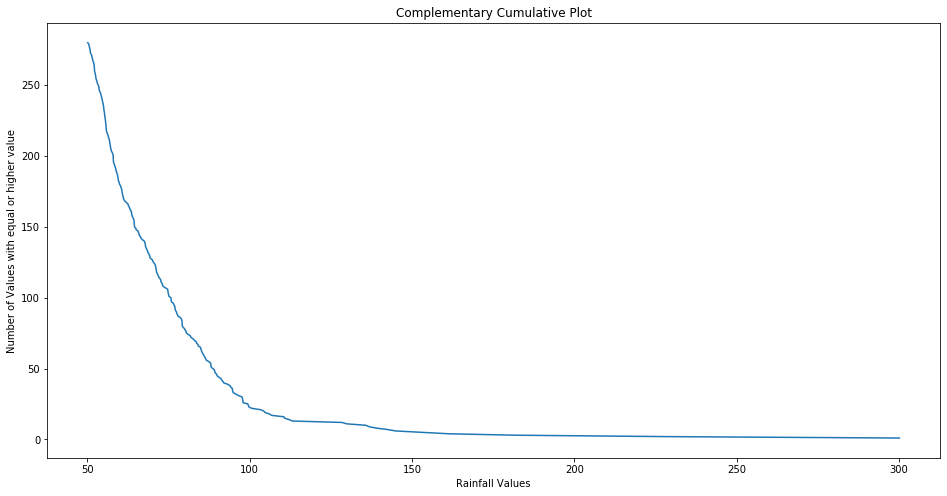

In [8]:
lower_bound = 50

bounded_count = dict()

for rain_value in rainfall_series:
    
    if rain_value <= lower_bound:
        continue
    
    if rain_value not in bounded_count:
        bounded_count[rain_value] = 1
    else:
        bounded_count[rain_value] += 1
        
rainfall_count = list(bounded_count.items())
rainfall_count.sort(key=lambda rain_count: rain_count[0])
rainfall_arr, count_arr = list(zip(*rainfall_count))
count_cusum_rev = [0] * len(count_arr)

count_cusum_rev[-1] = count_arr[-1]
for i in range(len(count_cusum_rev) - 2, -1, -1):
    count_cusum_rev[i] = count_cusum_rev[i + 1] + count_arr[i]

plt.figure(figsize=(16, 8))
plt.plot(rainfall_arr, count_cusum_rev)
plt.xlabel('Rainfall Values')
plt.ylabel('Number of Values with equal or higher value')
plt.title('Complementary Cumulative Plot')
plt.show()

## Computing Threshold Exceedances

In [9]:
threshold = 50 # Rainfall in mm

exceed_series = []

for i in range(rainfall_series.shape[0]):
    
    if rainfall_series[i] > threshold:
        exceed_series.append(rainfall_series[i] - threshold)
        
exceed_series = np.array(exceed_series)

print(f'Exceedances Series: datatype: {exceed_series.dtype}, '
    + f'shape: {exceed_series.shape}')

Exceedances Series: datatype: float64, shape: (280,)


# Parameter Estimation of GEV fitted to Remainder Series

Shape Parameter: 0.062011174188271144 
Scale Parameter: 22.279025409865067 
Log Likelihood: -1165.8976266592238


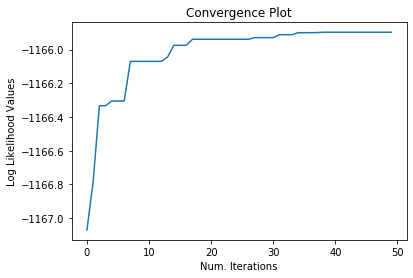

In [10]:
params, max_log_likelihood, max_log_likelihood_vals = GpdEstimate.psoMethod(
    exceed_series,
    Pso.computeInitialPos([(-10, 10), (5, 30)], 200),
    numIterations=50
)

shape, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [11]:
gpd_dist = GeneralizedParetoDistribution(*tuple(params))

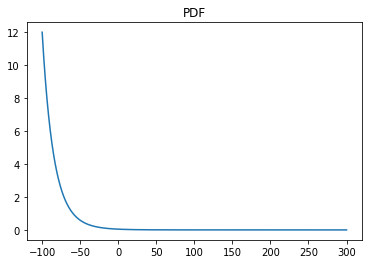

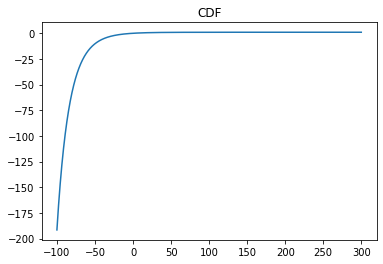

In [12]:
x = np.linspace(-100, 300, 10000)

plt.plot(x, gpd_dist.pdf(x))
plt.title('PDF')
plt.show()

plt.plot(x, gpd_dist.cdf(x))
plt.title('CDF')
plt.show()

# Algorithm

## Part 1: Extreme Value CDF Prediction Algorithm

### Build Model Architecture

In [13]:
lag = 50

model_extreme = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model_extreme.build(input_shape=(None, lag))
model_extreme.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Build Training Data

In [14]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (217, 50)
Output Data: datatype: float64, shape: (217, 1)


In [15]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  0. ,  0. ,  0. , 47. ,  5. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        18. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  2.6,  1.6,  3. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  1.6,  0. , 10.6,  0. ,  0. , 25.2,
         0. ,  0. , 16.6,  5. , 14. , 14.2,  8.8,  2.6, 13. ,  1.2,  0. ,
         0. , 22.6, 33.6,  8.6, 18.6, 32.6],
       [ 0. ,  0. ,  3. ,  5.2, 11. ,  5. ,  2. ,  0. ,  0.8, 39. , 31.4,
        30.4, 15.2, 21. ,  2.8,  2. ,  0. ,  7.6,  6.2, 31. ,  9. , 19. ,
        12.8, 17. ,  0. ,  0. ,  2. , 20. ,  5. ,  2.6, 36. ,  1. , 25. ,
        16. ,  7. , 15. , 10. , 26. , 20. , 25.2, 12.2, 41.6,  6. ,  2. ,
         0. , 40. ,  0. , 38.8, 19. ,  9.6],
       [ 0. ,  3. ,  5.2, 11. ,  5. ,  2. ,  0. ,  0.8, 39. , 31.4, 30.4,
        15.2, 21. ,  2.8,  2. ,  0. ,  7.6,  6.2, 31. ,  9. , 19. , 12.8,
        17. ,  0. ,  0. ,  2. , 20. ,  5. ,  2.6, 36. ,  1. , 25. , 16. ,
         7. , 15. , 10. , 26. , 20. , 25.2, 12.2, 41.6,  6. ,  2. ,  0. ,
    

### Train the Model

Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1826
Epoch 2/100
7/7 [==============================] - 0s 973us/step - loss: 0.1119
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1119
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0819
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0718
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0657
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0587
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0467
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0396
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0289
Epoch 12/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0249
Epoch 13/100
7/7 [==============================] - 0s 2ms/

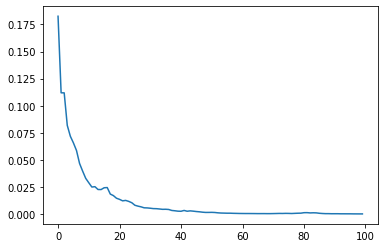

In [16]:
history = model_extreme.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Compute Test Loss

In [17]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))
        
        output_actual.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)
output_actual = np.expand_dims(np.array(output_actual), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)
pred_actual = threshold + gpd_dist.computeQuantile(pred_val)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss (CDF): {test_loss_cdf}')

test_loss = MeanSquaredError()(output_actual, pred_actual)
print(f'Test Loss (Actual): {test_loss}')

Input Test Data: datatype: float64, shape: (63, 50)
Output Test Data: datatype: float64, shape: (63, 1)

Test Loss (CDF): 0.15124012529850006
Test Loss (Actual): 1655.253662109375


## Part 2: Extreme Value Detection (Classification) Algorithm

In [26]:
model_detect = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])

pos_weight = 1000

def loss_func(labels, logits):
    
    loss_tensor = \
        tf.nn.weighted_cross_entropy_with_logits(
            labels, logits, pos_weight
        )
    
    loss_value = tf.reduce_mean(loss_tensor)
    
    return loss_value
    
    
model_detect.build(input_shape=(None, lag))
model_detect.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.10, 50, 0.9
        )
    ),
    loss=loss_func
)

### Build Training Data

In [27]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    input_data.append(rainfall_series[i - lag: i])
    
    if rainfall_series[i] > threshold:
        output_data.append(1.0)
    
    else:
        output_data.append(0.0)

        
input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (14954, 50)
Output Data: datatype: float64, shape: (14954, 1)


In [28]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. , 45. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
    

Epoch 1/100
468/468 [==============================] - 0s 735us/step - loss: 409.0231
Epoch 2/100
468/468 [==============================] - 0s 728us/step - loss: 24.1960
Epoch 3/100
468/468 [==============================] - 0s 732us/step - loss: 3.6865
Epoch 4/100
468/468 [==============================] - 0s 722us/step - loss: 3.6802
Epoch 5/100
468/468 [==============================] - 0s 731us/step - loss: 3.6738
Epoch 6/100
468/468 [==============================] - 0s 731us/step - loss: 3.6689
Epoch 7/100
468/468 [==============================] - 0s 742us/step - loss: 3.6687
Epoch 8/100
468/468 [==============================] - 1s 1ms/step - loss: 3.6679
Epoch 9/100
468/468 [==============================] - 0s 827us/step - loss: 3.6676
Epoch 10/100
468/468 [==============================] - 0s 839us/step - loss: 3.6674
Epoch 11/100
468/468 [==============================] - 0s 896us/step - loss: 3.6673
Epoch 12/100
468/468 [==============================] - 0s 846us/step - l

468/468 [==============================] - 0s 721us/step - loss: 3.6673
Epoch 98/100
468/468 [==============================] - 0s 681us/step - loss: 3.6673
Epoch 99/100
468/468 [==============================] - 0s 702us/step - loss: 3.6673
Epoch 100/100
468/468 [==============================] - 0s 741us/step - loss: 3.6673


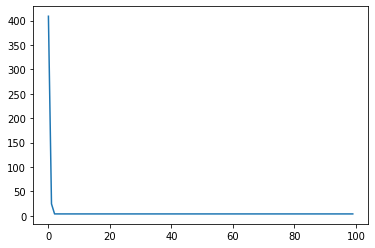

In [29]:
history = model_detect.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

## Compute Test Loss

In [35]:
input_data = []
output_data = []

for i in range(max(num_train, lag), n):
    
    input_data.append(rainfall_series[i - lag: i])
    
    if rainfall_series[i] > threshold:
        output_data.append(1.0)
    
    else:
        output_data.append(0.0)

input_data = np.array(input_data, dtype=np.float32)
output_data = np.expand_dims(np.array(output_data, dtype=np.float32), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_detect.predict(input_data)

test_loss = loss_func(true_val, pred_val)
print(f'Test Loss: {test_loss}')

Input Test Data: datatype: float32, shape: (2648, 50)
Output Test Data: datatype: float32, shape: (2648, 1)

Test Loss: 4.280692100524902


## Part 3: Normal Value Prediction Algorithm

In [42]:
model_normal = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])    
    
model_normal.build(input_shape=(None, lag))
model_normal.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=MeanSquaredError()
)

### Build Training Data

In [43]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (14737, 50)
Output Data: datatype: float64, shape: (14737, 1)


In [44]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. , 45. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
    

Epoch 1/100
461/461 [==============================] - 0s 800us/step - loss: 48.9046
Epoch 2/100
461/461 [==============================] - 0s 737us/step - loss: 45.2645
Epoch 3/100
461/461 [==============================] - 0s 721us/step - loss: 44.0336
Epoch 4/100
461/461 [==============================] - 0s 804us/step - loss: 43.4668
Epoch 5/100
461/461 [==============================] - 0s 720us/step - loss: 43.1045
Epoch 6/100
461/461 [==============================] - 0s 741us/step - loss: 42.9741
Epoch 7/100
461/461 [==============================] - 0s 728us/step - loss: 42.9269
Epoch 8/100
461/461 [==============================] - 0s 722us/step - loss: 42.9038
Epoch 9/100
461/461 [==============================] - 0s 753us/step - loss: 42.8955
Epoch 10/100
461/461 [==============================] - 0s 929us/step - loss: 42.8928
Epoch 11/100
461/461 [==============================] - 0s 992us/step - loss: 42.8913
Epoch 12/100
461/461 [==============================] - 0s 812u

461/461 [==============================] - 0s 781us/step - loss: 42.8906
Epoch 97/100
461/461 [==============================] - 0s 683us/step - loss: 42.8907
Epoch 98/100
461/461 [==============================] - 0s 688us/step - loss: 42.8907
Epoch 99/100
461/461 [==============================] - 0s 800us/step - loss: 42.8907
Epoch 100/100
461/461 [==============================] - 0s 700us/step - loss: 42.8906


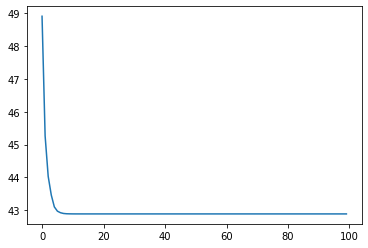

In [45]:
history = model_normal.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

## Compute Test Loss

In [48]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss: {test_loss_cdf}')

Input Test Data: datatype: float64, shape: (2585, 50)
Output Test Data: datatype: float64, shape: (2585, 1)

Test Loss: 90.361572265625


# Combining Algorithms

## Forecasting Training Data

In [50]:
input_data = []
output_data = []

for i in range(lag, num_train):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (14954, 50)
Output Test Data: datatype: float64, shape: (14954, 1)



In [56]:
pred_outputs = []

for i in tqdm(range(input_data.shape[0])):
    
    x = (input_data[i])[np.newaxis, :]
    
    # Is Extreme ?
    is_extreme = bool(tf.sigmoid(
        model_detect.predict(x)
    ).numpy() > 0.5)
    
    if is_extreme:
        pred = gpd_dist.computeQuantile(model_extreme.predict(x)) \
            + threshold
        
    else:
        pred = model_normal.predict(x)
        
    pred = float(pred)
    pred_outputs.append(pred)
    
pred_outputs = np.array(pred_outputs)
print(f'Output Shape: {pred_outputs.shape}')

100%|██████████| 14954/14954 [14:10<00:00, 17.87it/s]

Output Shape: (14954,)


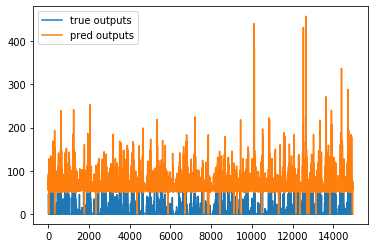

In [57]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_outputs, label='pred outputs')
plt.legend()
plt.show()

## Forecasting Test Data

In [58]:
input_data = []
output_data = []

for i in range(max(num_train, lag), n):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (2648, 50)
Output Test Data: datatype: float64, shape: (2648, 1)



In [59]:
pred_outputs = []

for i in tqdm(range(input_data.shape[0])):
    
    x = (input_data[i])[np.newaxis, :]
    
    # Is Extreme ?
    is_extreme = bool(tf.sigmoid(
        model_detect.predict(x)
    ).numpy() > 0.5)
    
    if is_extreme:
        pred = gpd_dist.computeQuantile(model_extreme.predict(x)) \
            + threshold
        
    else:
        pred = model_normal.predict(x)
        
    pred = float(pred)
    pred_outputs.append(pred)
    
pred_outputs = np.array(pred_outputs)
print(f'Output Shape: {pred_outputs.shape}')

 39%|███▉      | 1032/2648 [00:58<01:28, 18.27it/s]/Users/ahmed/Programming/Project/Forecast/ts/experimental/genpareto.py:44: RuntimeWarning: divide by zero encountered in power
  return self.scaleParam * ((1 - p) ** (-self.shapeParam) - 1) / self.shapeParam
100%|██████████| 2648/2648 [02:31<00:00, 17.83it/s]

Output Shape: (2648,)


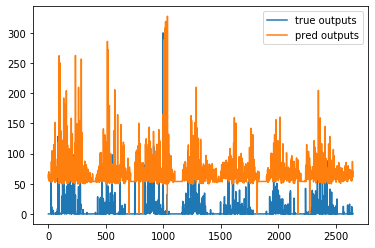

In [60]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_outputs, label='pred outputs')
plt.legend()
plt.show()